In [4]:
import pandas as pd
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from afinn import Afinn

In [5]:
def process_transcripts(data_directory: Path, label_df: pd.DataFrame) -> None:
    """
    Reads all transcript files, separates participant and Ellie speech,
    and saves them to two separate CSV files.

    Args:
        data_directory (Path): The path to the main folder containing all 
                               the XXX_P participant folders.
        label_df (pd.DataFrame): A DataFrame containing the 'Participant_ID's 
                                 to process.
    """
    all_participant_data = []
    all_ellie_data = []
    
    print("Starting transcript processing...")
    
    for participant_id in label_df['Participant_ID']:
        transcript_path = data_directory / f"{participant_id}_P" / f"{participant_id}_TRANSCRIPT.csv"
        
        if not transcript_path.exists():
            print(f"Warning: Transcript for participant {participant_id} not found. Skipping.")
            continue
            
        try:
            # Reads the tab-separated transcript file
            transcript_df = pd.read_csv(transcript_path, sep='\t')
            
            # Adds participant ID column for context
            transcript_df['participant_id'] = participant_id
            
            # Separates the speakers
            participant_speech = transcript_df[transcript_df['speaker'] == 'Participant'].copy()
            ellie_speech = transcript_df[transcript_df['speaker'] == 'Ellie'].copy()
            
            all_participant_data.append(participant_speech)
            all_ellie_data.append(ellie_speech)
            
        except Exception as e:
            print(f"Error processing transcript for participant {participant_id}: {e}")

    # Concatenates all dataframes into two final ones
    if all_participant_data:
        final_participant_df = pd.concat(all_participant_data, ignore_index=True)
        final_participant_df.to_csv('data/participant_speech.csv', index=False)
        print("\nSuccessfully saved 'participant_speech.csv'")
    else:
        print("\nNo participant speech data was processed.")
        
    if all_ellie_data:
        final_ellie_df = pd.concat(all_ellie_data, ignore_index=True)
        final_ellie_df.to_csv('data/ellie_questions.csv', index=False)
        print("Successfully saved 'ellie_questions.csv'")
    else:
        print("No Ellie speech data was processed.")
        
    print("\nProcessing complete.")

In [ ]:
if __name__ == '__main__':
    # Define the path to your main data directory
    # (the one that contains the 300_P, 301_P, etc. folders)
    DATA_PATH = Path('data/extracted_folders/')
    
    # Load the split files to get the list of participants
    train_split_path = 'data/train_split_Depression_AVEC2017.csv'
    dev_split_path = 'data/dev_split_Depression_AVEC2017.csv'
    
    train_df = pd.read_csv(train_split_path)
    dev_df = pd.read_csv(dev_split_path)
    
    # Combine train and dev splits to process all relevant participants at once
    all_participants_df = pd.concat([train_df, dev_df], ignore_index=True)
    
    # 3. Run the processing function
    process_transcripts(data_directory=DATA_PATH, label_df=all_participants_df)

Starting transcript processing...


TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [6]:
def create_final_dataset(speech_csv_path: Path, labels_csv_path: Path, output_csv_path: Path) -> pd.DataFrame:
    """
    Loads participant speech, aggregates it into single documents per participant,
    merges it with labels, and saves the final model-ready dataset.

    Args:
        speech_csv_path (Path): Path to the 'participant_speech.csv' file.
        labels_csv_path (Path): Path to the label file (e.g., train_split.csv).
        output_csv_path (Path): Path to save the final output CSV file.

    Returns:
        pd.DataFrame: The final, merged, and cleaned DataFrame.
    """
    try:
        print(f"Reading speech data from: {speech_csv_path}")
        speech_df = pd.read_csv(speech_csv_path)
        
        print(f"Reading labels from: {labels_csv_path}")
        labels_df = pd.read_csv(labels_csv_path)

        print("Aggregating text for each participant")
        aggregated_text_df = speech_df.groupby('participant_id')['value'].apply(lambda x: ' '.join(x.astype(str))).reset_index()
        aggregated_text_df.rename(columns={'value': 'text'}, inplace=True)
        
        print("Merging aggregated text with labels")
        merged_df = pd.merge(
            aggregated_text_df, 
            labels_df, 
            left_on='participant_id', 
            right_on='Participant_ID'
        )
        
        # Select only the required columns
        final_df = merged_df[['participant_id', 'text', 'PHQ8_Binary']].copy()
        
        print(f"Saving final dataset to: {output_csv_path}")
        final_df.to_csv(output_csv_path, index=False)
        
        print("Successfully created final classification dataset.")
        return final_df

    except FileNotFoundError as e:
        print(f"Error: File not found. Please check your paths. Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [7]:
if __name__ == '__main__':
    # Defining the base path to your data
    DATA_PATH = Path('data/')

    # Processing the Training Data
    print("Processing Training Data")
    create_final_dataset(
        speech_csv_path=DATA_PATH / 'participant_speech.csv',
        labels_csv_path=DATA_PATH / 'train_split_Depression_AVEC2017.csv',
        output_csv_path=DATA_PATH / 'final_training_dataset.csv'
    )
    
    # Processing the Development (Validation) Data
    # We use the same participant_speech.csv file, but merge with the dev labels
    print("\nProcessing Development Data")
    create_final_dataset(
        speech_csv_path=DATA_PATH / 'participant_speech.csv',
        labels_csv_path=DATA_PATH / 'dev_split_Depression_AVEC2017.csv',
        output_csv_path=DATA_PATH / 'final_dev_dataset.csv'
    )

Processing Training Data
Reading speech data from: data/participant_speech.csv
Reading labels from: data/train_split_Depression_AVEC2017.csv
Aggregating text for each participant
Merging aggregated text with labels
Saving final dataset to: data/final_training_dataset.csv
Successfully created final classification dataset.

Processing Development Data
Reading speech data from: data/participant_speech.csv
Reading labels from: data/dev_split_Depression_AVEC2017.csv
Aggregating text for each participant
Merging aggregated text with labels
Saving final dataset to: data/final_dev_dataset.csv
Successfully created final classification dataset.


In [8]:
def verify_single_participant(processed_row: pd.Series, raw_data_path: Path, labels_df: pd.DataFrame) -> bool:
    """
    Verifies a single participant's processed data against the original raw files.

    Args:
        processed_row (pd.Series): A single row from the processed DataFrame.
        raw_data_path (Path): Path to the directory containing XXX_P folders.
        labels_df (pd.DataFrame): The original DataFrame of labels.

    Returns:
        bool: True if verification is successful, False otherwise.
    """
    participant_id = processed_row['participant_id']
    processed_text = processed_row['text']
    processed_label = processed_row['PHQ8_Binary']

    print(f"Verifying Participant ID: {participant_id}")

    # Verifying the Text
    transcript_path = raw_data_path / f"{participant_id}_P" / f"{participant_id}_TRANSCRIPT.csv"
    if not transcript_path.exists():
        print(f"[FAIL] Original transcript file not found.")
        return False

    original_transcript_df = pd.read_csv(transcript_path, sep='\t')
    participant_speech = original_transcript_df[original_transcript_df['speaker'] == 'Participant']
    
    # Recreates the aggregated text from the original source
    recreated_text = ' '.join(participant_speech['value'].astype(str))

    if processed_text != recreated_text:
        print(f"[FAIL] Text mismatch for participant {participant_id}.")
        # printing lengths to debug
        print(f"Processed text length: {len(processed_text)}")
        print(f"Recreated text length: {len(recreated_text)}")
        return False
    
    print(f"[SUCCESS] Text verified.")

    # Verifying the Label
    original_label_row = labels_df[labels_df['Participant_ID'] == participant_id]
    if original_label_row.empty:
        print(f"[FAIL] Participant ID not found in original label file.")
        return False
        
    original_label = original_label_row['PHQ8_Binary'].iloc[0]

    if processed_label != original_label:
        print(f"[FAIL] Label mismatch for participant {participant_id}.")
        print(f"Processed label: {processed_label}")
        print(f"Original label: {original_label}")
        return False

    print(f"[SUCCESS] Label verified.")
    
    print(f"Verification for {participant_id} successful\n")
    return True

In [11]:
if __name__ == '__main__':
    # Define paths
    DATA_PATH = Path('data/')
    RAW_DATA_PATH = Path('data/extracted_folders/')

    # Load your newly created processed dataset
    final_dataset = pd.read_csv(DATA_PATH / 'final_training_dataset.csv')
    
    # Load the original labels file
    original_labels = pd.read_csv(DATA_PATH / 'train_split_Depression_AVEC2017.csv')

    print(f"Verifying all {len(final_dataset)} participants in the dataset...")
    all_verified = True
    for index, row in final_dataset.iterrows():
        if not verify_single_participant(
            processed_row=row,
            raw_data_path=RAW_DATA_PATH,
            labels_df=original_labels
        ):
            all_verified = False
            break
    
    if all_verified:
        print("\nAll participants verified successfully!")

Verifying all 107 participants in the dataset...
Verifying Participant ID: 303
[SUCCESS] Text verified.
[SUCCESS] Label verified.
Verification for 303 successful

Verifying Participant ID: 304
[SUCCESS] Text verified.
[SUCCESS] Label verified.
Verification for 304 successful

Verifying Participant ID: 305
[SUCCESS] Text verified.
[SUCCESS] Label verified.
Verification for 305 successful

Verifying Participant ID: 310
[SUCCESS] Text verified.
[SUCCESS] Label verified.
Verification for 310 successful

Verifying Participant ID: 312
[SUCCESS] Text verified.
[SUCCESS] Label verified.
Verification for 312 successful

Verifying Participant ID: 313
[SUCCESS] Text verified.
[SUCCESS] Label verified.
Verification for 313 successful

Verifying Participant ID: 315
[SUCCESS] Text verified.
[SUCCESS] Label verified.
Verification for 315 successful

Verifying Participant ID: 316
[SUCCESS] Text verified.
[SUCCESS] Label verified.
Verification for 316 successful

Verifying Participant ID: 317
[SUCCESS]

# 1. Exploratory Data Analysis (EDA) - The Ground Truth
Before building any models, it's crucial to understand the distribution of our target labels. This helps us understand the nature of our dataset and guides our choice of evaluation metrics.

## 1.1 Class Balance Analysis
First, we will analyze the class balance of our target variable, `PHQ8_Binary`. This tells us the percentage of participants in the dataset who are labeled as depressed versus not depressed. Understanding this balance is critical, as a significant imbalance will mean that simple accuracy is a misleading metric, and we should prioritize metrics like the F1-Score.

In [15]:
def analyze_class_balance(df: pd.DataFrame, target_column: str = 'PHQ8_Binary'):
    """
    Calculates and prints the class balance of a binary target column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_column (str): The name of the binary label column.
    """
    if target_column not in df.columns:
        print(f"Error: Column '{target_column}' not found in DataFrame.")
        return

    class_counts = df[target_column].value_counts()
    class_percentages = df[target_column].value_counts(normalize=True) * 100

    print("Class Balance:")
    print(f"  - Not Depressed (0): {class_counts[0]} participants ({class_percentages[0]:.2f}%)")
    print(f"  - Depressed (1):     {class_counts[1]} participants ({class_percentages[1]:.2f}%)")

In [13]:
training_data_path = 'data/final_training_dataset.csv'
train_df = pd.read_csv(training_data_path)

In [16]:
analyze_class_balance(train_df)

Class Balance:
  - Not Depressed (0): 77 participants (71.96%)
  - Depressed (1):     30 participants (28.04%)


In [22]:
def plot_class_distribution(df: pd.DataFrame, target_column: str = 'PHQ8_Binary'):
    """
    Plots a bar chart of the class distribution for a binary target column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_column (str): The name of the binary label column.
    """
    if target_column not in df.columns:
        print(f"Error: Column '{target_column}' not found in DataFrame.")
        return
        
    plt.figure(figsize=(8, 6))
    sns.countplot(x=target_column, data=df, palette='pastel')
    plt.title('Class Distribution of Depression Labels', fontsize=16)
    plt.xlabel('Depression Label (PHQ8_Binary)', fontsize=12)
    plt.ylabel('Number of Participants', fontsize=12)
    plt.xticks(ticks=[0, 1], labels=['Not Depressed', 'Depressed'])
    
    # Add counts on top of the bars
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    
    plt.show()

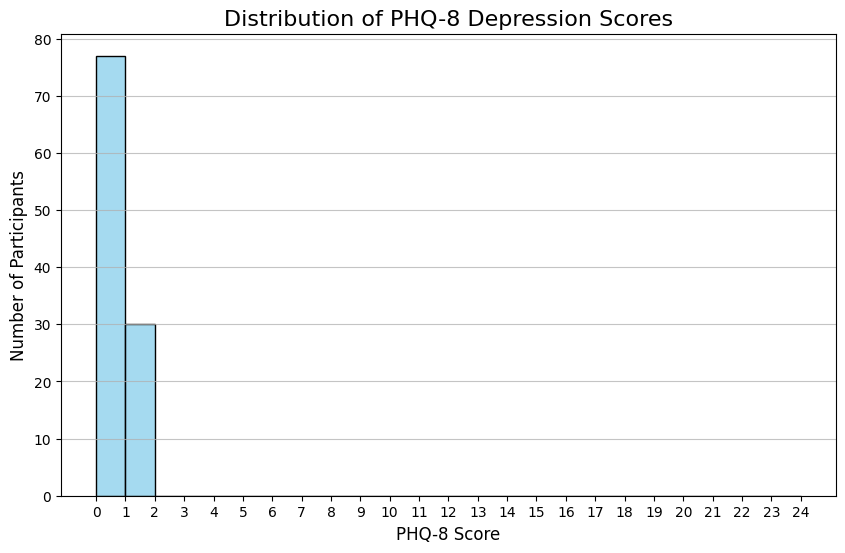

In [23]:
plot_score_distribution(train_df)

## 2. Basic Text Statistics
Now that we understand our labels, let's analyze the general characteristics of the text itself. We will compare two key metrics between the depressed and non-depressed groups: **interview length** (word count) and **vocabulary richness** (unique word count). This can reveal high-level patterns in communication styles. For instance, do individuals with depression tend to be more verbose or less so? Do they use a wider or more limited vocabulary?

In [24]:
def analyze_text_statistics(df: pd.DataFrame, text_column: str = 'text', label_column: str = 'PHQ8_Binary'):
    """
    Calculates and plots the distribution of word count and unique word count,
    comparing between the two classes in the label column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        text_column (str): The name of the text column.
        label_column (str): The name of the binary label column.
    """
    if text_column not in df.columns or label_column not in df.columns:
        print(f"Error: Required columns not found in DataFrame.")
        return

    # Calculates word count and unique word count for each transcript
    df['word_count'] = df[text_column].apply(lambda x: len(str(x).split()))
    df['unique_word_count'] = df[text_column].apply(lambda x: len(set(str(x).split())))

    # Creates a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plots Word Count
    sns.boxplot(x=label_column, y='word_count', data=df, ax=axes[0], palette='pastel')
    axes[0].set_title('Interview Length (Word Count) by Group', fontsize=16)
    axes[0].set_xlabel('Depression Label', fontsize=12)
    axes[0].set_ylabel('Total Words', fontsize=12)
    axes[0].set_xticklabels(['Not Depressed (0)', 'Depressed (1)'])

    # Plots Unique Word Count (Vocabulary Richness)
    sns.boxplot(x=label_column, y='unique_word_count', data=df, ax=axes[1], palette='pastel')
    axes[1].set_title('Vocabulary Richness by Group', fontsize=16)
    axes[1].set_xlabel('Depression Label', fontsize=12)
    axes[1].set_ylabel('Unique Words', fontsize=12)
    axes[1].set_xticklabels(['Not Depressed (0)', 'Depressed (1)'])

    plt.tight_layout()
    plt.show()

    # Prints the median values for a more precise comparison
    print("Median Values by Group:")
    print(df.groupby(label_column)[['word_count', 'unique_word_count']].median())

/tmp/ipykernel_30/2030322361.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=label_column, y='word_count', data=df, ax=axes[0], palette='pastel')
/tmp/ipykernel_30/2030322361.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Not Depressed (0)', 'Depressed (1)'])
/tmp/ipykernel_30/2030322361.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=label_column, y='unique_word_count', data=df, ax=axes[1], palette='pastel')
/tmp/ipykernel_30/2030322361.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fixed

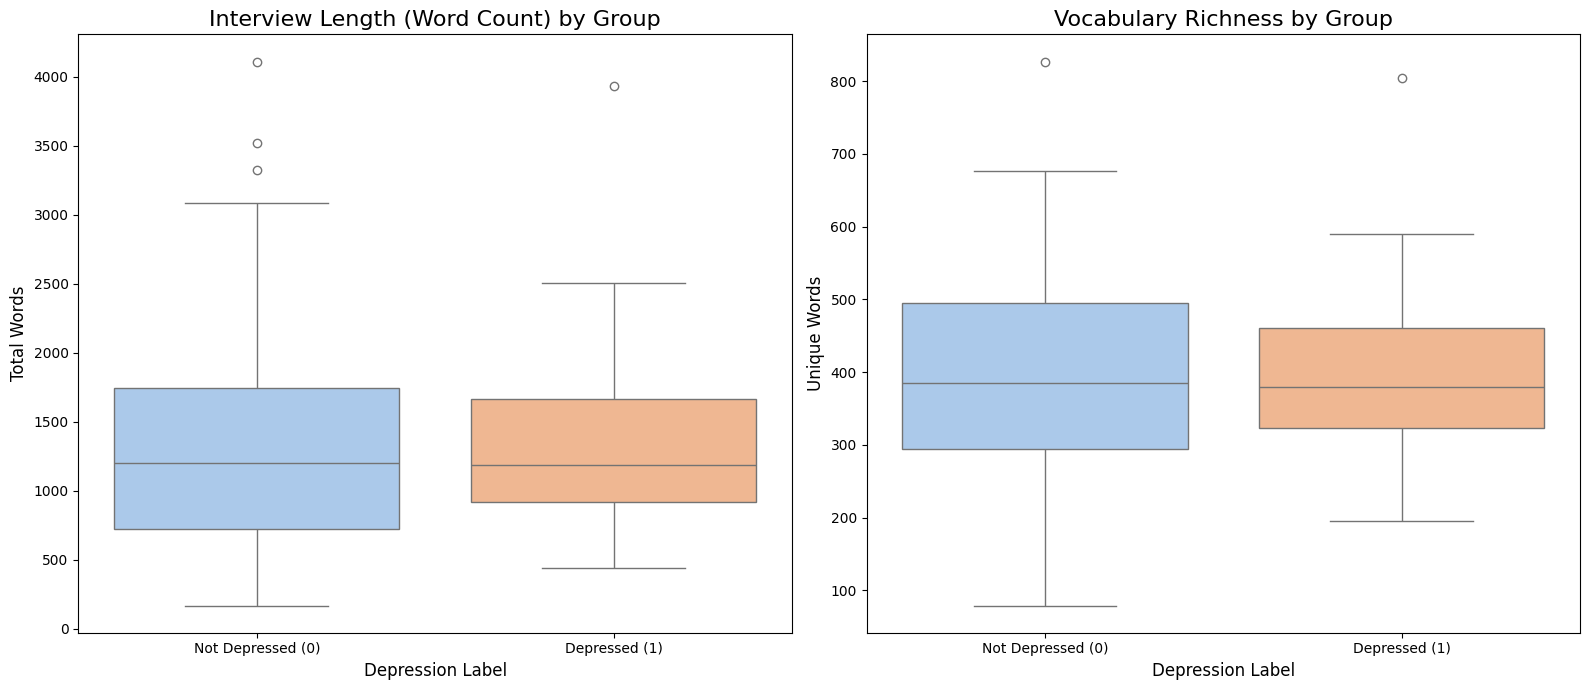

Median Values by Group:
             word_count  unique_word_count
PHQ8_Binary                               
0                1204.0              385.0
1                1184.5              380.0


In [25]:
analyze_text_statistics(train_df)

## 3. N-Gram Analysis
N-gram analysis is at the core of our text EDA. By breaking down the interview transcripts into common words (unigrams), two-word phrases (bigrams), and three-word phrases (trigrams), we can identify specific linguistic patterns that differentiate the depressed and non-depressed groups. We will remove common English stop words to ensure our analysis focuses on the most meaningful terms.

In [41]:
def plot_top_ngrams(df: pd.DataFrame, title: str, color: str, ax):
    """Helper function to plot a bar chart of top n-grams."""
    sns.barplot(x='count', y='ngram', data=df, color=color, ax=ax)
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('N-Gram')
    
custom_stop_words = [
    'um', 'uh', 'like', 'yeah', 'know', 'just', 'really', 'kinda', 'sort',
    'laughter', 'sniff', 'sigh', 'mhm', 'mm', 'don', 've'
]
combined_stop_words = list(ENGLISH_STOP_WORDS) + custom_stop_words

In [44]:
def analyze_ngrams(df: pd.DataFrame, text_column: str = 'text', label_column: str = 'PHQ8_Binary', top_n: int = 20):
    """
    Analyzes and visualizes the top N-grams for depressed and non-depressed groups.
    """
    # Separates the text data for each group
    depressed_text = df[df[label_column] == 1][text_column]
    not_depressed_text = df[df[label_column] == 0][text_column]

    # N-Gram Extraction Function
    def get_top_ngrams(corpus, ngram_range, top_n):
        vec = CountVectorizer(ngram_range=ngram_range, stop_words=combined_stop_words).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return pd.DataFrame(words_freq[:top_n], columns=['ngram', 'count'])

    # Unigrams
    unigrams_dep = get_top_ngrams(depressed_text, (1, 1), top_n)
    unigrams_not_dep = get_top_ngrams(not_depressed_text, (1, 1), top_n)
    
    # Bigrams
    bigrams_dep = get_top_ngrams(depressed_text, (2, 2), top_n)
    bigrams_not_dep = get_top_ngrams(not_depressed_text, (2, 2), top_n)

    # Trigrams
    trigrams_dep = get_top_ngrams(depressed_text, (3, 3), top_n)
    trigrams_not_dep = get_top_ngrams(not_depressed_text, (3, 3), top_n)

    # Prints the lists
    print("--- Top 20 Unigrams ---")
    print("\nDepressed Group:\n", list(unigrams_dep['ngram']))
    print("\nNot Depressed Group:\n", list(unigrams_not_dep['ngram']))

    print("\n--- Top 20 Bigrams ---")
    print("\nDepressed Group:\n", list(bigrams_dep['ngram']))
    print("\nNot Depressed Group:\n", list(bigrams_not_dep['ngram']))

    print("\n--- Top 20 Trigrams ---")
    print("\nDepressed Group:\n", list(trigrams_dep['ngram']))
    print("\nNot Depressed Group:\n", list(trigrams_not_dep['ngram']))

    # Plots the results
    fig, axes = plt.subplots(3, 2, figsize=(20, 30))
    plot_top_ngrams(unigrams_dep, 'Top Unigrams (Depressed)', 'salmon', axes[0, 0])
    plot_top_ngrams(unigrams_not_dep, 'Top Unigrams (Not Depressed)', 'skyblue', axes[0, 1])
    plot_top_ngrams(bigrams_dep, 'Top Bigrams (Depressed)', 'salmon', axes[1, 0])
    plot_top_ngrams(bigrams_not_dep, 'Top Bigrams (Not Depressed)', 'skyblue', axes[1, 1])
    plot_top_ngrams(trigrams_dep, 'Top Trigrams (Depressed)', 'salmon', axes[2, 0])
    plot_top_ngrams(trigrams_not_dep, 'Top Trigrams (Not Depressed)', 'skyblue', axes[2, 1])
    
    plt.tight_layout()
    plt.show()

--- Top 20 Unigrams ---

Depressed Group:
 ['people', 'think', 'lot', 'things', 'good', 'time', 'probably', 'yes', 'say', 'pretty', 'life', 'hard', 'little', 'guess', 'feel', 'oh', 'try', 'years', 'mean', 'better']

Not Depressed Group:
 ['good', 'think', 'people', 'things', 'time', 'pretty', 'lot', 'little', 'say', 'probably', 'life', 'feel', 'years', 'guess', 'different', 'going', 'yes', 'got', 'didn', 'went']

--- Top 20 Bigrams ---

Depressed Group:
 ['little bit', 'years ago', 'clears throat', 'pretty good', 'best friend', 'new york', 'los angeles', 'dream job', 'long time', 'high school', 'lot things', 'deep breath', 'lot better', 'lot people', 'hard question', 'hours sleep', 'yes okay', 'think little', 'think think', 'days ago']

Not Depressed Group:
 ['little bit', 'years ago', 'clears throat', 'pretty good', 'deep breath', 'dream job', 'los angeles', 'long time', 'high school', 'best friend', 'pretty easy', 'synch yes', 'feel guilty', 'hardest decision', 'different things', 'n

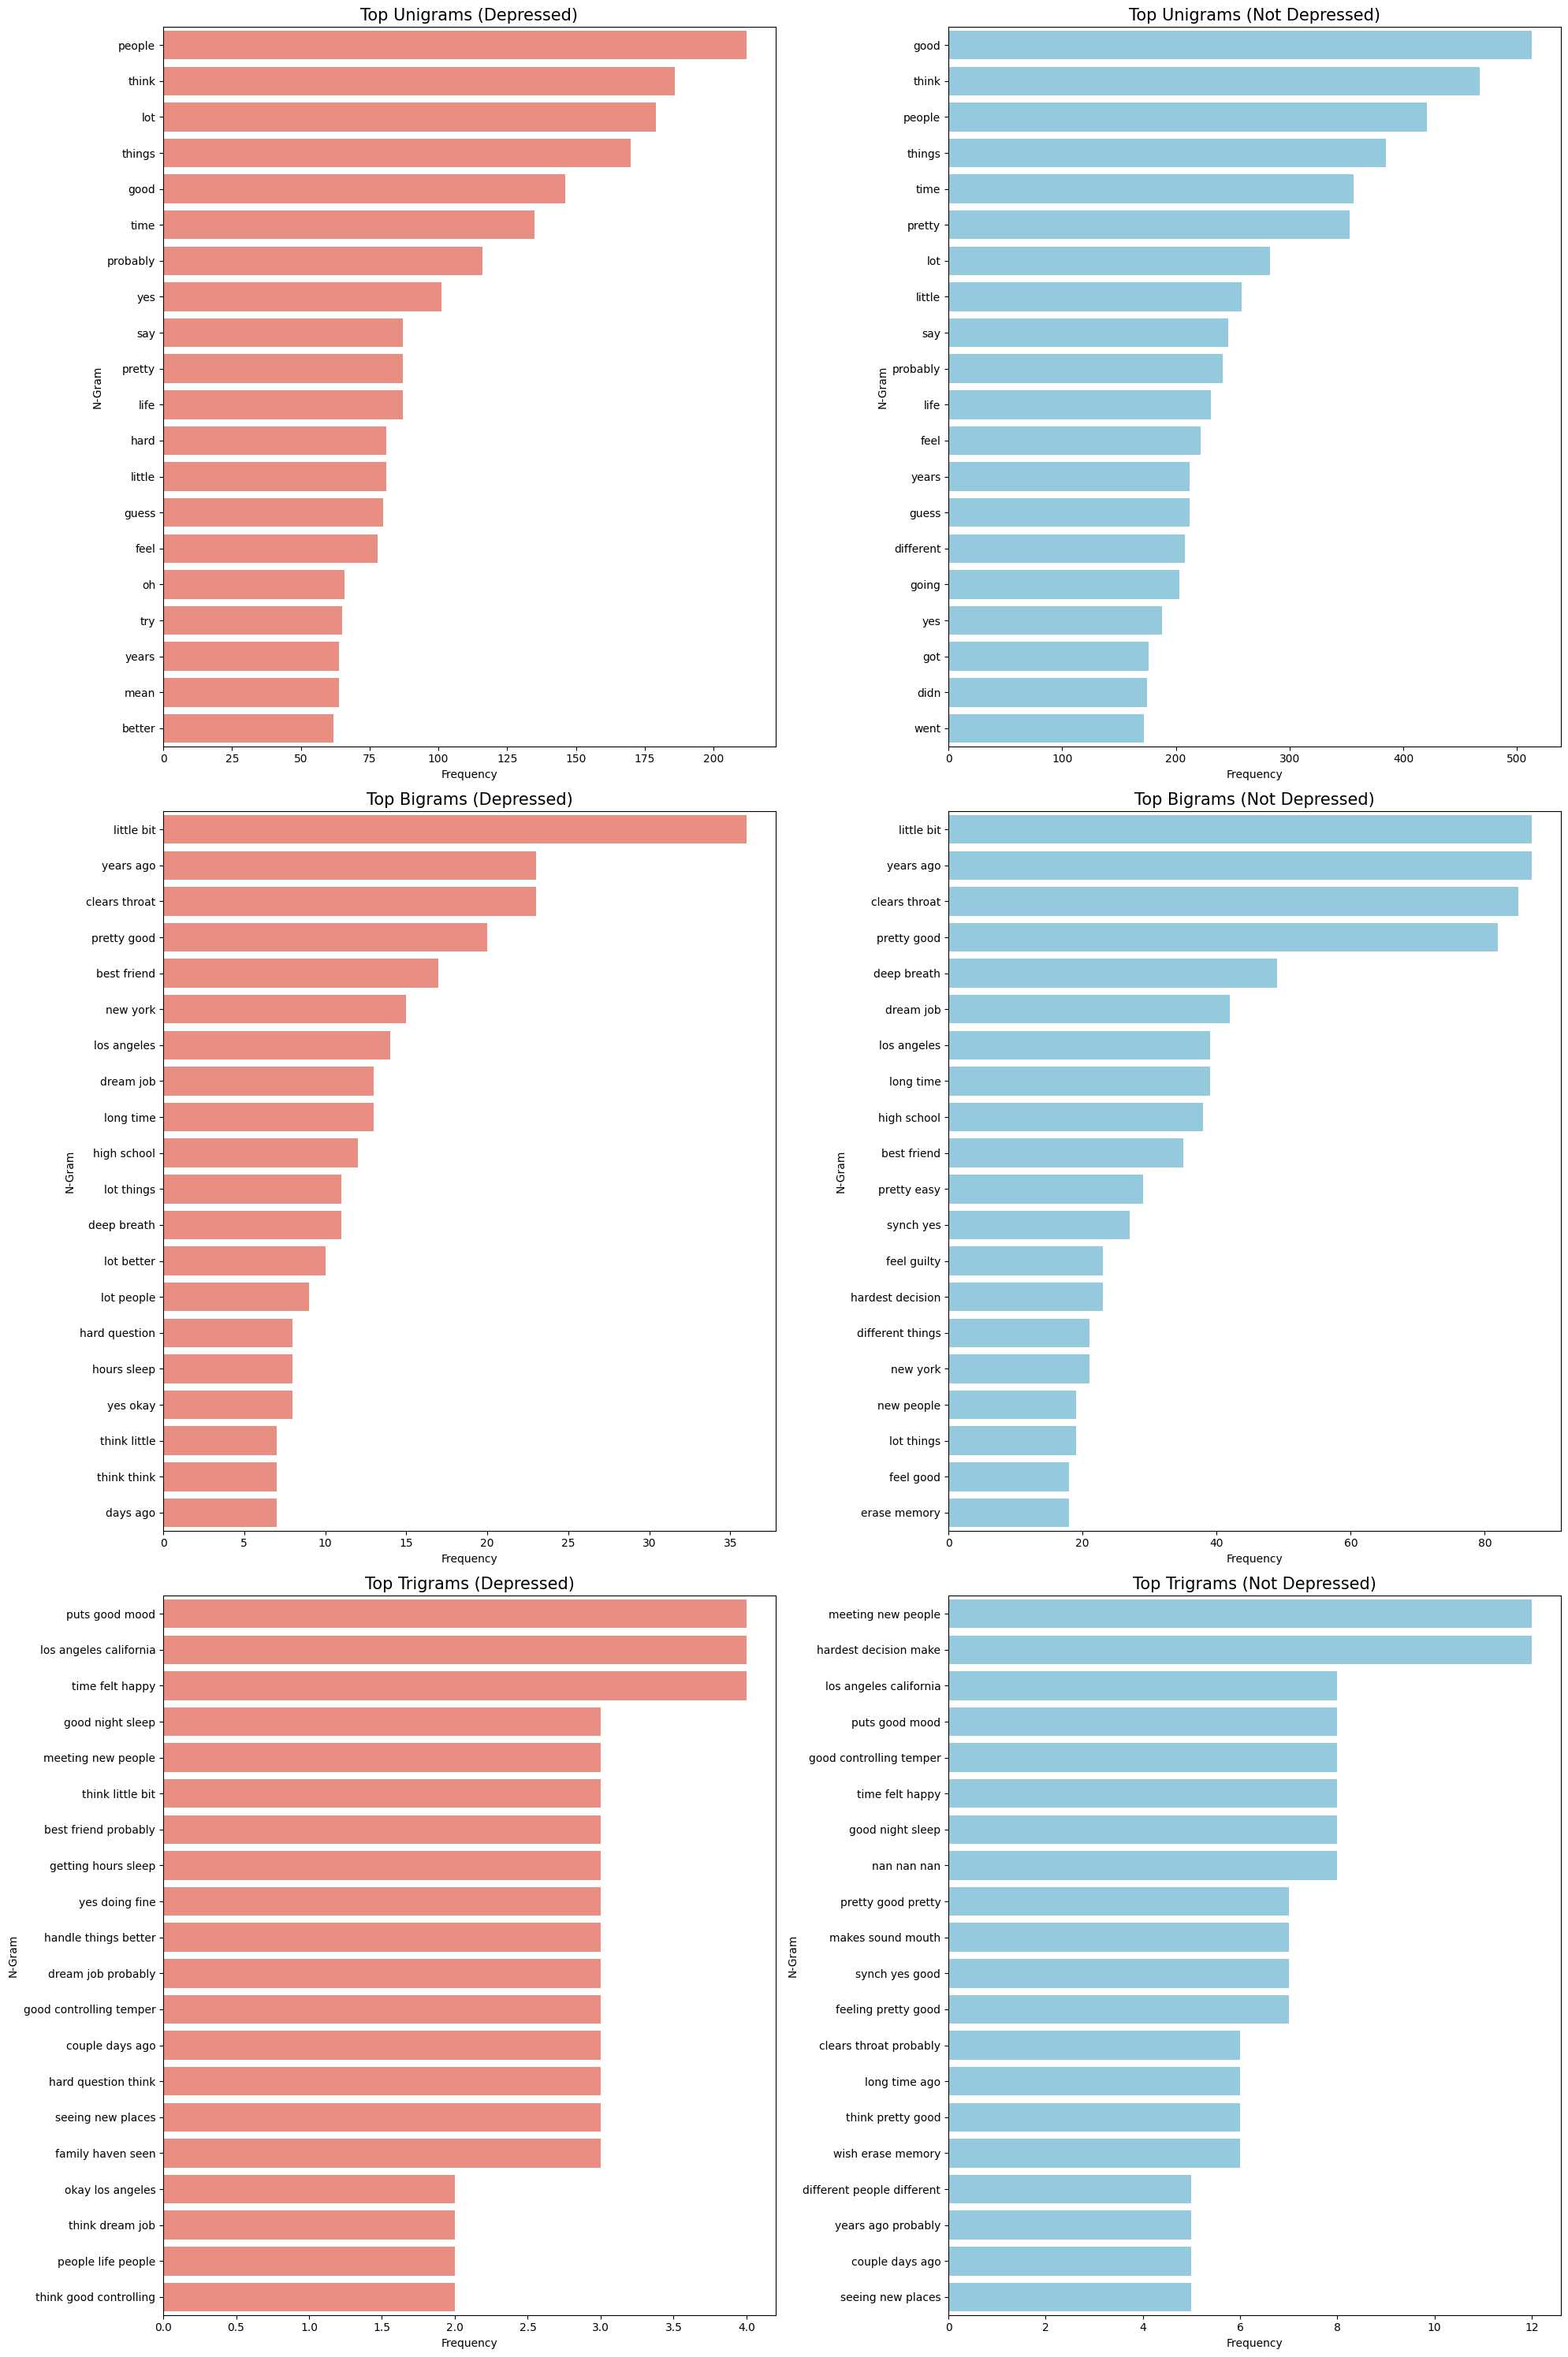

In [45]:
analyze_ngrams(train_df)

In [46]:
def analyze_top_tfidf_words(df: pd.DataFrame, text_column: str = 'text', label_column: str = 'PHQ8_Binary', top_n: int = 20):
    """
    Calculates and prints the top N words for each class based on TF-IDF scores.
    """
    # Separates the documents for each class
    depressed_docs = df[df[label_column] == 1][text_column]
    not_depressed_docs = df[df[label_column] == 0][text_column]

    def get_top_tfidf(corpus, group_name):
        # Uses the entire dataset's text to fit the vectorizer
        # This ensures the IDF part is calculated correctly across all documents
        vectorizer = TfidfVectorizer(max_features=5000, stop_words=combined_stop_words).fit(df[text_column])
        
        # Transforms only the documents for the specific group
        transformed = vectorizer.transform(corpus)
        
        # Calculate the average TF-IDF score for each word across the group's documents
        avg_tfidf = transformed.mean(axis=0).tolist()[0]
        feature_names = vectorizer.get_feature_names_out()
        
        word_scores = pd.DataFrame({'word': feature_names, 'score': avg_tfidf})
        top_words = word_scores.sort_values(by='score', ascending=False).head(top_n)
        
        print(f"\nTop {top_n} TF-IDF Words for '{group_name}' Group")
        print(list(top_words['word']))

    get_top_tfidf(depressed_docs, 'Depressed')
    get_top_tfidf(not_depressed_docs, 'Not Depressed')

In [47]:
analyze_top_tfidf_words(train_df)


Top 20 TF-IDF Words for 'Depressed' Group
['people', 'lot', 'think', 'things', 'good', 'probably', 'time', 'yes', 'guess', 'pretty', 'feel', 'say', 'life', 'hard', 'better', 'little', 'try', 'basically', 'oh', 'help']

Top 20 TF-IDF Words for 'Not Depressed' Group
['good', 'think', 'people', 'pretty', 'things', 'time', 'guess', 'little', 'probably', 'say', 'lot', 'different', 'feel', 'yes', 'life', 'years', 'didn', 'going', 'right', 'mean']


In [48]:
def find_differentiating_words(df: pd.DataFrame, text_column: str = 'text', label_column: str = 'PHQ8_Binary', top_n: int = 20):
    """
    Finds the most characteristic words for each class using TF-IDF scores.
    """
    # Separates the text for each group into a single document
    depressed_text = " ".join(df[df[label_column] == 1][text_column])
    not_depressed_text = " ".join(df[df[label_column] == 0][text_column])

    # Creates a TF-IDF vectorizer and transform the two documents
    vectorizer = TfidfVectorizer(max_features=5000, stop_words=combined_stop_words)
    tfidf_matrix = vectorizer.fit_transform([depressed_text, not_depressed_text])
    
    # Gets the feature names (words)
    feature_names = vectorizer.get_feature_names_out()
    
    # Creates a DataFrame with the scores
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names, index=['Depressed', 'Not Depressed'])
    
    # Transposes the DataFrame to have words as rows
    tfidf_df = tfidf_df.T
    
    # Calculates the difference in scores
    tfidf_df['difference'] = tfidf_df['Depressed'] - tfidf_df['Not Depressed']

    print(f"\nTop {top_n} Most Characteristic Words for 'Depressed' Group")
    print(list(tfidf_df.sort_values(by='difference', ascending=False).head(top_n).index))

    print(f"\nTop {top_n} Most Characteristic Words for 'Not Depressed' Group")
    print(list(tfidf_df.sort_values(by='difference', ascending=True).head(top_n).index))

In [49]:
find_differentiating_words(train_df)


Top 20 Most Characteristic Words for 'Depressed' Group
['lot', 'people', 'yes', 'help', 'basically', 'better', 'sleep', 'probably', 'things', 'hard', 'movie', 'son', 'therapist', 'person', 'couldn', 'night', 'try', 'started', 'talk', 'depressed']

Top 20 Most Characteristic Words for 'Not Depressed' Group
['good', 'pretty', 'actually', 'got', 'work', 'way', 'wish', 'little', 'different', 'did', 'years', 'nice', 'relationship', 'wanna', 'family', 'friends', 'going', 'shy', 'eh', 'snort']


In [50]:
def generate_word_cloud_text(df: pd.DataFrame, text_column: str = 'text', label_column: str = 'PHQ8_Binary'):
    """
    Separates text by class, removes stop words, and prints the final
    text strings ready for an online word cloud generator.
    """
    # Separates the text for each group into a single string
    depressed_text = " ".join(df[df[label_column] == 1][text_column].astype(str))
    not_depressed_text = " ".join(df[df[label_column] == 0][text_column].astype(str))

    # Filters stop words from each text corpus
    depressed_words = [word for word in depressed_text.split() if word.lower() not in combined_stop_words]
    not_depressed_words = [word for word in not_depressed_text.split() if word.lower() not in combined_stop_words]

    # Joins the filtered words back into a single string and print
    final_depressed_text = " ".join(depressed_words)
    final_not_depressed_text = " ".join(not_depressed_words)
    
    print("Copy the text below for the 'Depressed' Group Word Cloud")
    print(final_depressed_text)
    
    print("\n" + "="*50 + "\n")
    
    print("Copy the text below for the 'Not Depressed' Group Word Cloud")
    print(final_not_depressed_text)

In [51]:
generate_word_cloud_text(train_df)

Copy the text below for the 'Depressed' Group Word Cloud
sure okay los angeles <laughter> that's good question familiarity city that's say right spread hard places dream job don't think dream job isn't i'm unemployed right <sigh> <cough> that's true <sniffle> started studied urban planning think school shooting thing n_r_a wanna budge gun control issue thing that's try remove situation that's annoying <sniffle> i've gotten better years time try walk away control emotions terms walking away watch t_v hmm say children born children birth speical <sniffle> unique experience time it's lot easier they're adults challenging say seeing children grow successful exceeding expectations worry time worry 'em i'm certainly worry 'em saw children oh week ago i'm usually pretty happy 'em <sigh> girlfriend insignificant l_a maybe that's <cough> excuse don't travel don't funds anymore health yes i'd say year recognizing things wrong knew wrong 'cause wasn't tired excited things anymore lethargic laying

## 4. Analysis of Psychological Markers: Pronoun Usage
Beyond general word frequencies, we can analyze specific linguistic markers that have been psychologically linked to mental states. A well-researched marker for depression is a heightened self-focus, which can manifest as an increased use of first-person singular pronouns (e.g., "I", "me", "my").

In this step, we will calculate the frequency of these pronouns for each participant and compare the distributions between the depressed and non-depressed groups.

In [53]:
def analyze_pronoun_usage(df: pd.DataFrame, text_column: str = 'text', label_column: str = 'PHQ8_Binary'):
    """
    Analyzes the frequency of first-person singular pronouns and compares
    the distribution between the two classes.
    """
    # Defines the first-person singular pronouns to count
    pronouns = ['i', 'me', 'my', 'myself']

    # Function to count the pronouns in a text
    def count_pronouns(text):
        # Using regex to find whole words to avoid matching parts of words (e.g., 'me' in 'blame')
        count = 0
        for p in pronouns:
            count += len(re.findall(r'\b' + p + r'\b', str(text).lower()))
        return count

    # Calculating pronoun count and word count
    df['pronoun_count'] = df[text_column].apply(count_pronouns)
    df['word_count'] = df[text_column].apply(lambda x: len(str(x).split()))
    
    # Calculating pronoun frequency as a percentage of total words
    # Added a small epsilon to avoid division by zero for any empty texts
    df['pronoun_frequency'] = (df['pronoun_count'] / (df['word_count'] + 1e-6)) * 100

    # Plots the results
    plt.figure(figsize=(10, 7))
    sns.boxplot(x=label_column, y='pronoun_frequency', data=df, palette='pastel')
    plt.title('First-Person Pronoun Frequency by Group', fontsize=16)
    plt.xlabel('Depression Label', fontsize=12)
    plt.ylabel('Pronoun Frequency (%)', fontsize=12)
    plt.xticks(ticks=[0, 1], labels=['Not Depressed (0)', 'Depressed (1)'])
    plt.show()
    
    # Prints the median values for a more precise comparison
    print("Median First-Person Pronoun Frequency (%):")
    print(df.groupby(label_column)['pronoun_frequency'].median())
    

/tmp/ipykernel_30/1985193319.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=label_column, y='pronoun_frequency', data=df, palette='pastel')


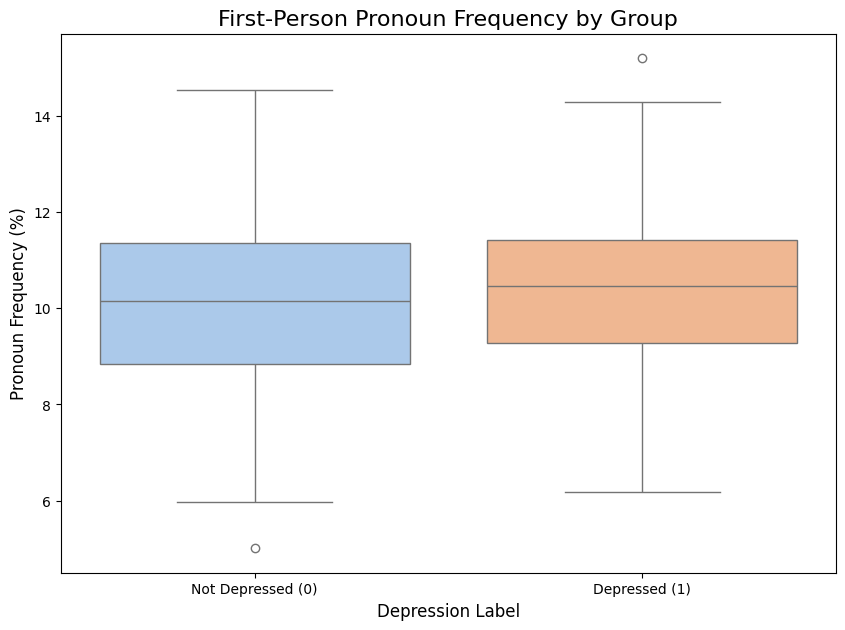

Median First-Person Pronoun Frequency (%):
PHQ8_Binary
0    10.141988
1    10.457370
Name: pronoun_frequency, dtype: float64


In [54]:
analyze_pronoun_usage(train_df)

## 5. Analysis of Emotional Valence
To further understand the linguistic differences, we will now analyze the emotional valence of the language used by each group. By scoring the sentiment of each interview, we can quantitatively measure whether the language used by the depressed group is, on average, more negative than the language used by the non-depressed group. We will calculate a normalized sentiment score for each participant and compare the distributions.

In [55]:
def analyze_emotional_valence(df: pd.DataFrame, text_column: str = 'text', label_column: str = 'PHQ8_Binary'):
    """
    Analyzes the emotional valence (sentiment) of the text and compares
    the distribution between the two classes.
    """
    # Initializes the Afinn sentiment analyzer
    afinn = Afinn()

    # Function to calculate a normalized sentiment score
    def calculate_sentiment(text):
        score = afinn.score(str(text))
        word_count = len(str(text).split())
        if word_count == 0:
            return 0
        # Normalizes the score by the length of the text
        return score / word_count

    # Calculates sentiment score for each transcript
    df['sentiment_score'] = df[text_column].apply(calculate_sentiment)

    # Plot the results
    plt.figure(figsize=(10, 7))
    sns.boxplot(x=label_column, y='sentiment_score', data=df, palette='pastel')
    plt.title('Normalized Sentiment Score by Group', fontsize=16)
    plt.xlabel('Depression Label', fontsize=12)
    plt.ylabel('Average Sentiment Score per Word', fontsize=12)
    plt.xticks(ticks=[0, 1], labels=['Not Depressed (0)', 'Depressed (1)'])
    plt.axhline(y=0, color='grey', linestyle='--') # Add a line at zero for reference
    plt.show()
    
    # Prints the median values for a more precise comparison
    print("Median Normalized Sentiment Score:")
    print(df.groupby(label_column)['sentiment_score'].median())

/tmp/ipykernel_30/979273590.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=label_column, y='sentiment_score', data=df, palette='pastel')


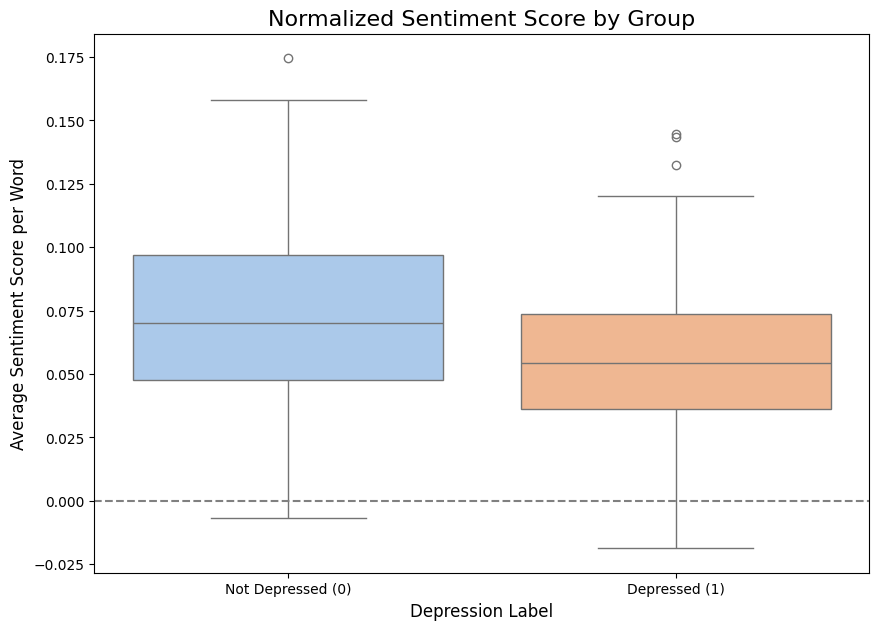

Median Normalized Sentiment Score:
PHQ8_Binary
0    0.070099
1    0.054379
Name: sentiment_score, dtype: float64


In [59]:
analyze_emotional_valence(train_df)

## 6. Analysis of Absolutist Language
A key linguistic marker sometimes associated with depression is the use of absolutist or dichotomous language (e.g., "always," "never," "nothing," "everything"). This type of black-and-white thinking can be a cognitive indicator of distress.

In this step, we will calculate the frequency of a predefined list of absolutist words for each participant and compare the distributions between the depressed and non-depressed groups to see if this pattern exists in our data.

"In an Absolute State: Erotic and Anxious Language in Online Mental Health Forums" by Mohammed Al-Mosaiwi and Tom Johnstone, published in the journal Clinical Psychological Science in 2018.

In [60]:
def analyze_absolutist_words(df: pd.DataFrame, text_column: str = 'text', label_column: str = 'PHQ8_Binary'):
    """
    Analyzes the frequency of absolutist words and compares
    the distribution between the two classes.
    """
    # Defines a list of common absolutist words
    absolutist_words = [
        'all', 'always', 'complete', 'completely', 'constant', 'constantly', 
        'definitely', 'entire', 'ever', 'every', 'everyone', 'everything', 
        'full', 'must', 'never', 'no one', 'nobody', 'none', 'nothing', 
        'totally', 'whole'
    ]

    # Function to count the absolutist words in a text
    def count_absolutist(text):
        count = 0
        for word in absolutist_words:
            # Use regex to find whole words
            count += len(re.findall(r'\b' + word + r'\b', str(text).lower()))
        return count

    # Calculates absolutist word count and total word count
    df['absolutist_count'] = df[text_column].apply(count_absolutist)
    df['word_count'] = df[text_column].apply(lambda x: len(str(x).split()))
    
    # Calculates the frequency as a percentage
    df['absolutist_frequency'] = (df['absolutist_count'] / (df['word_count'] + 1e-6)) * 100

    # Plots the results
    plt.figure(figsize=(10, 7))
    sns.boxplot(x=label_column, y='absolutist_frequency', data=df, palette='pastel')
    plt.title('Absolutist Word Frequency by Group', fontsize=16)
    plt.xlabel('Depression Label', fontsize=12)
    plt.ylabel('Absolutist Word Frequency (%)', fontsize=12)
    plt.xticks(ticks=[0, 1], labels=['Not Depressed (0)', 'Depressed (1)'])
    plt.show()
    
    # Print the median values for a more precise comparison
    print("Median Absolutist Word Frequency (%):")
    print(df.groupby(label_column)['absolutist_frequency'].median())

/tmp/ipykernel_30/3525860256.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=label_column, y='absolutist_frequency', data=df, palette='pastel')


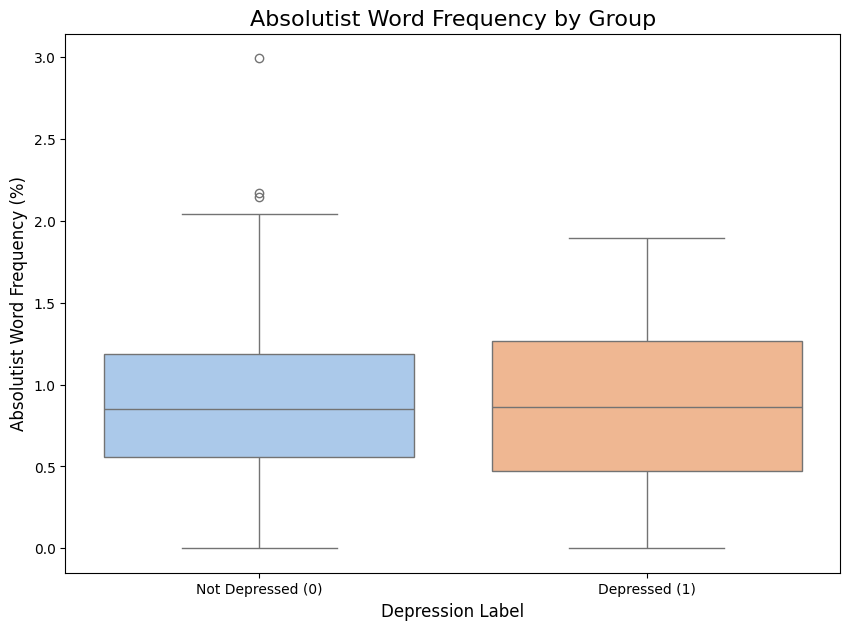

Median Absolutist Word Frequency (%):
PHQ8_Binary
0    0.849257
1    0.863803
Name: absolutist_frequency, dtype: float64


In [61]:
analyze_absolutist_words(train_df)